Training model 1/5
Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - color_output_accuracy: 0.2024 - color_output_loss: 4.2376 - color_output_precision: 0.4782 - color_output_recall: 0.0762 - loss: 8.0251 - type_output_accuracy: 0.1536 - type_output_loss: 3.7871 - type_output_precision: 0.4326 - type_output_recall: 0.0225 - val_color_output_accuracy: 0.3037 - val_color_output_loss: 3.1180 - val_color_output_precision: 0.7876 - val_color_output_recall: 0.1648 - val_loss: 5.8960 - val_type_output_accuracy: 0.3870 - val_type_output_loss: 2.7802 - val_type_output_precision: 0.8452 - val_type_output_recall: 0.1315
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - color_output_accuracy: 0.3243 - color_output_loss: 2.9171 - color_output_precision: 0.6981 - color_output_recall: 0.1664 - loss: 5.3382 - type_output_accuracy: 0.3861 - type_output_loss: 2.4210 - type_output_precision: 0.7301 - type_output_recall: 0.1754 - val_color_output_accuracy: 0.3685 - val_color_output_loss: 2.8562 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/s

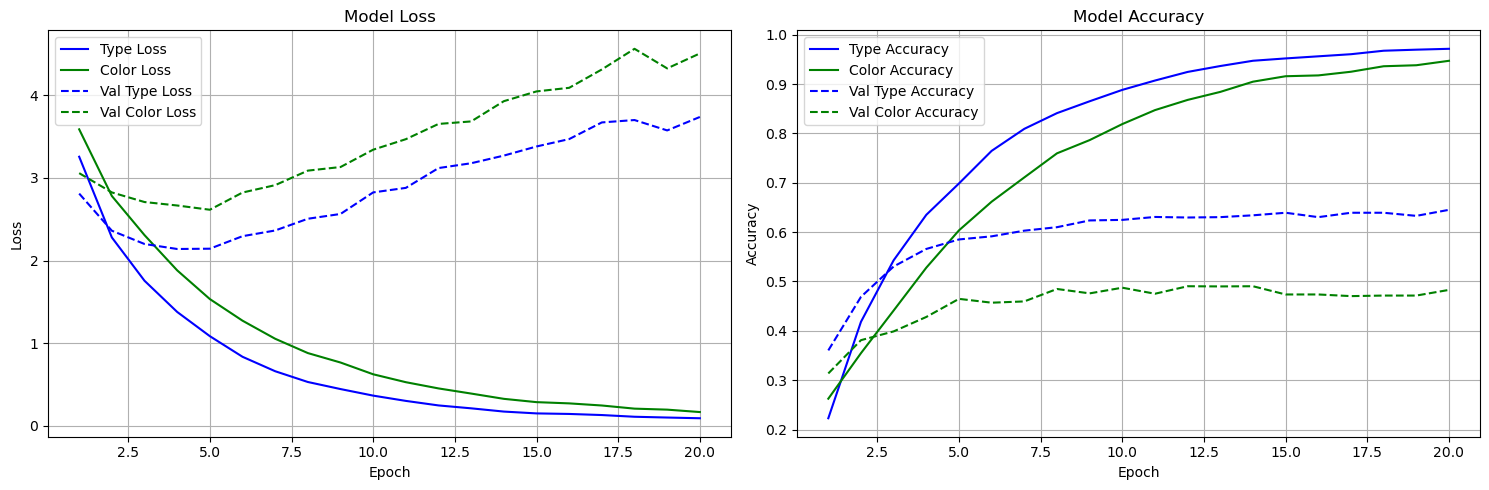

In [9]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt

def load_dataset(folder_path):
    images = []
    types = []
    colors = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            name_part = filename.rsplit('.', 1)[0]
            type_and_color = name_part.split('_', 1)

            item_type = type_and_color[0].split()[-1].strip().lower()
            color = type_and_color[1].split()[-1].strip().lower()

            if color != "unknown":
                types.append(item_type)
                colors.append(color)

                img = Image.open(os.path.join(folder_path, filename)).resize((128, 128))
                images.append(np.array(img) / 255.0)

    return np.array(images), types, colors

aritzia_folder = 'aritzia_images'
ami_folder = 'ami_images'
maje_folder = 'maje_images'

aritzia_images, aritzia_types, aritzia_colors = load_dataset(aritzia_folder)
ami_images, ami_types, ami_colors = load_dataset(ami_folder)
maje_images, maje_types, maje_colors = load_dataset(maje_folder)

all_images = np.concatenate([aritzia_images, ami_images, maje_images], axis=0)
all_types = aritzia_types + ami_types + maje_types
all_colors = aritzia_colors + ami_colors + maje_colors

type_encoder = pd.factorize(pd.Series(all_types))
color_encoder = pd.factorize(pd.Series(all_colors))

type_labels = tf.keras.utils.to_categorical(type_encoder[0], num_classes=len(type_encoder[1]))
color_labels = tf.keras.utils.to_categorical(color_encoder[0], num_classes=len(color_encoder[1]))

X_train, X_val, y_type_train, y_type_val, y_color_train, y_color_val = train_test_split(
    all_images, type_labels, color_labels, test_size=0.2, random_state=42
)

def build_model():
    input_layer = tf.keras.layers.Input(shape=(128, 128, 3))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    shared_features = tf.keras.layers.Flatten()(x)

    type_x = tf.keras.layers.Dense(512, activation='relu')(shared_features)
    type_x = tf.keras.layers.Dropout(0.5)(type_x)
    type_output = tf.keras.layers.Dense(len(type_encoder[1]), activation='softmax', name='type_output')(type_x)

    color_x = tf.keras.layers.Dense(512, activation='relu')(shared_features)
    color_x = tf.keras.layers.Dropout(0.5)(color_x)
    color_output = tf.keras.layers.Dense(len(color_encoder[1]), activation='softmax', name='color_output')(color_x)

    model = tf.keras.models.Model(inputs=input_layer, outputs={'type_output': type_output, 'color_output': color_output})

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'type_output': 'categorical_crossentropy',
            'color_output': 'categorical_crossentropy'
        },
        metrics={
            'type_output': ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
            'color_output': ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
        }
    )
    return model

n_models = 5
models = []

def bootstrap_data(X, y_type, y_color, n_samples):
    indices = np.random.choice(len(X), n_samples, replace=True)
    return X[indices], y_type[indices], y_color[indices]

histories = []
for i in range(n_models):
    print(f"Training model {i + 1}/{n_models}")

    X_train_boot, y_type_train_boot, y_color_train_boot = bootstrap_data(X_train, y_type_train, y_color_train, len(X_train))
    
    model = build_model()
    history = model.fit(
        X_train_boot,
        {'type_output': y_type_train_boot, 'color_output': y_color_train_boot},
        validation_data=(X_val, {'type_output': y_type_val, 'color_output': y_color_val}),
        epochs=20,
        batch_size=32,
        verbose=1
    )
    histories.append(history.history)
    models.append(model)

def aggregate_predictions(models, X):
    type_preds = np.zeros((len(X), len(type_encoder[1])))
    color_preds = np.zeros((len(X), len(color_encoder[1])))

    for model in models:
        preds = model.predict(X)
        type_preds += preds['type_output']
        color_preds += preds['color_output']

    type_preds /= len(models)
    color_preds /= len(models)

    return type_preds, color_preds

type_preds, color_preds = aggregate_predictions(models, X_val)

type_preds_classes = np.argmax(type_preds, axis=1)
color_preds_classes = np.argmax(color_preds, axis=1)

type_val_classes = np.argmax(y_type_val, axis=1)
color_val_classes = np.argmax(y_color_val, axis=1)

type_accuracy = np.mean(type_preds_classes == type_val_classes)
color_accuracy = np.mean(color_preds_classes == color_val_classes)

type_precision = precision_score(type_val_classes, type_preds_classes, average='weighted')
type_recall = recall_score(type_val_classes, type_preds_classes, average='weighted')
color_precision = precision_score(color_val_classes, color_preds_classes, average='weighted')
color_recall = recall_score(color_val_classes, color_preds_classes, average='weighted')

print(f"\nValidation Type Accuracy: {type_accuracy:.4f}")
print(f"Validation Type Precision: {type_precision:.4f}")
print(f"Validation Type Recall: {type_recall:.4f}")

print(f"\nValidation Color Accuracy: {color_accuracy:.4f}")
print(f"Validation Color Precision: {color_precision:.4f}")
print(f"Validation Color Recall: {color_recall:.4f}")

plt.style.use('default') 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

avg_type_loss = np.mean([h['type_output_loss'] for h in histories], axis=0)
avg_color_loss = np.mean([h['color_output_loss'] for h in histories], axis=0)
avg_val_type_loss = np.mean([h['val_type_output_loss'] for h in histories], axis=0)
avg_val_color_loss = np.mean([h['val_color_output_loss'] for h in histories], axis=0)

avg_type_acc = np.mean([h['type_output_accuracy'] for h in histories], axis=0)
avg_color_acc = np.mean([h['color_output_accuracy'] for h in histories], axis=0)
avg_val_type_acc = np.mean([h['val_type_output_accuracy'] for h in histories], axis=0)
avg_val_color_acc = np.mean([h['val_color_output_accuracy'] for h in histories], axis=0)

epochs = range(1, len(avg_type_loss) + 1)

ax1.plot(epochs, avg_type_loss, 'b-', label='Type Loss')
ax1.plot(epochs, avg_color_loss, 'g-', label='Color Loss')
ax1.plot(epochs, avg_val_type_loss, 'b--', label='Val Type Loss')
ax1.plot(epochs, avg_val_color_loss, 'g--', label='Val Color Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, avg_type_acc, 'b-', label='Type Accuracy')
ax2.plot(epochs, avg_color_acc, 'g-', label='Color Accuracy')
ax2.plot(epochs, avg_val_type_acc, 'b--', label='Val Type Accuracy')
ax2.plot(epochs, avg_val_color_acc, 'g--', label='Val Color Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
